<a href="https://colab.research.google.com/github/h0806449f/Pytorch/blob/main/DB_02_neural_network_clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# === Make classification data ===

In [ ]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
            noise=0.03,
            # random seeds
            random_state=42)


In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
print("First 5 samples of X:\n", X[:5])
print("First 5 samples of y:\n", y[:5])

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [ ]:
# DF of circle data
import pandas as pd

circles = pd.DataFrame( {"X1" : X[:,0],
               "X2" : X[:,1],
               "label" : y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


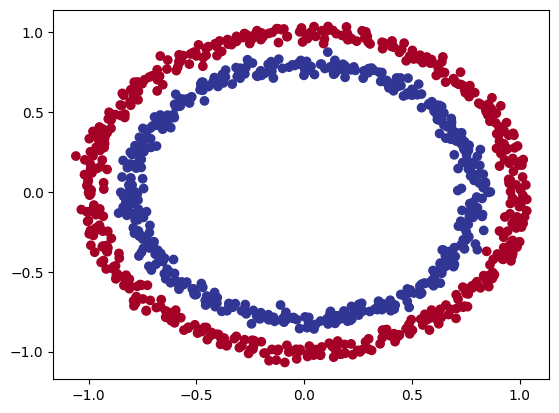

In [ ]:
# Visualize
import matplotlib.pyplot as plt

plt.scatter( x=X[:, 0],
        y=X[:, 1],
        c=y,
        cmap=plt.cm.RdYlBu )

# 1.1 Check data shape

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
# check 
X[0], y[0]

(array([0.75424625, 0.23148074]), 1)

# 1.2 Trun data into tensor and create train, test splits

In [ ]:
# Turn data into torch
import torch

X.dtype   # dtype('float64')

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X, X.dtype, y.dtype

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         ...,
         [-0.1369, -0.8100],
         [ 0.6704, -0.7675],
         [ 0.2811,  0.9638]]),
 torch.float32,
 torch.float32)

In [ ]:
# Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                              y,
                              test_size=0.2,
                              random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# === Build model ===  

1. Setup device
2. Construct model (by subclassing nn.module)
3. Define loss function and optimizer
4. Create training and testing loop

In [ ]:
# Import Pytorch and nn
import torch
from torch import nn

# Setup device
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cpu'

In [ ]:
# Create model
# 1. Subclass "nn.Module" (almost all models in Pytorch subclass "nn.Moudle")
# 2. Create 2 "nn.Linear()" layers (since our data got 2 classes)
# 3. Define "forward()"
# 4. Instatiate an instance of our model class and send it to the target device
# 將模型放置在運算設備上。PyTorch可以偵測運算設備，並根據該設備進行優化，例如使用GPU進行計算。

In [ ]:
# 1. Subclass nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        # 2. Create 2 nn.Linear (process the data)
        self.layer_1 = nn.Linear(in_features=2, out_features=8) # 2 -> upscales to 5 features
        self.layer_2 = nn.Linear(in_features=8, out_features=1)
    
    # 3. Define forward()
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instatiate an instance
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

In [ ]:
# 使用 nn.Sequential() 複製上面的模型
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=8, out_features=1)
).to(device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

In [ ]:
# 額外 : Make prediction
untrained_preds = model_1(X_test.to(device))

print("Length of prediction: ", len(untrained_preds))
print("Shape of prediction: ", untrained_preds.shape)

print("\nLength of test: ", len(X_test))
print("Shape of test: ", X_test.shape)

print("\nFirst 10 prediction", torch.round(untrained_preds[:10]))   # torch.round # 目前模型全部預測0
print("\nFirst 10 labels", y_test[:10])

Length of prediction:  200
Shape of prediction:  torch.Size([200, 1])

Length of test:  200
Shape of test:  torch.Size([200, 2])

First 10 prediction tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.]], grad_fn=<RoundBackward0>)

First 10 labels tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


# 2.1 Choose loss function and optimizer
1. For regression : usually MAE or MSE
2. For classification : usually binary cross entropy or categorical cross entropy
  
  
3. Optimizer : usually Adam or SGD 
4. More info : https://www.learnpytorch.io/02_pytorch_classification/

In [ ]:
# Setup loss function
# 這邊的問題是 binary 
loss_fn = nn.BCEWithLogitsLoss()   # sigmoid function build-in

optimizer = torch.optim.SGD(params=model_1.parameters(),
                lr=0.1)

In [ ]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

# === Train model ===
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. backward pass (Loss backward)
5. Optimizer (gradient descent)

# 3.1 Raw logits -> prediction probabilities -> prediction labels
logits 是指"未經過" softmax 函數處理的輸出值  
通常用於多類別分類任務的最後一層輸出，並且會作為損失函數的輸入。

In [ ]:
# View the first 5 outputs of the forward pass on the test data

# 轉換為 evaluate 模式
model_1.eval()

# 只是檢視最後預測值 所以關閉梯度計算
with torch.no_grad():
    y_logits = model_0(X_test.to(device))[:5]

# 比較 logits and y_test
y_logits, y_test[:5]

(tensor([[-0.3104],
         [-0.4788],
         [ 0.1177],
         [-0.4316],
         [ 0.0967]]),
 tensor([1., 0., 1., 0., 1.]))

In [ ]:
# 使用 sigmoid 激活 logits
# y_pred_probs < 0.5 將被歸類到 class 0 y=0
# y_pred_probs >= 0.5 將被歸類到 class 1 y=1

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

# sigmoid 激活後 -> round
y_pred = torch.round(y_pred_probs)

In [ ]:
# prediction labels # 將 cell 21 - 22 一次做完
# 使用 sigmoid 將 logits 轉為機率
# 使用 round 將機率 轉換為 0 or 1 labels
y_pred_labels = torch.round(torch.sigmoid(model_1(X_test.to(device))[:5]))
y_pred_labels

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<RoundBackward0>)

In [ ]:
# 檢查 預測值 與 test 是否一樣

y_pred_labels.squeeze(), y_test[:5]

(tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>),
 tensor([1., 0., 1., 0., 1.]))

# 3.2 Build training and testing loop

In [ ]:
torch.manual_seed(42)   # torch.cuda.manual_seed(42) 也可以

# set number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluate loop
for epoch in range(epochs):
    # Training !!!
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    # 1.1 turn logits into probilities and then trun into labels
    y_pred = torch.round(torch.sigmoid(y_logits)) 

    # 2. Calculate loss/accuracy
    # Loss function : nn.BCEWithLogitsLoss 需使用 logits 為input
    # Compare with y_train
    loss = loss_fn(y_logits,
             y_train)
    acc = accuracy_fn(y_true = y_train,
               y_pred = y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Test !!!
    model_1.eval()
    with torch.no_grad():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss/acc
        # Loss function : nn.BCEWithLogitsLoss 需使用 logits 為input
        # Compare with y_test
        test_loss = loss_fn(test_logits,
                    y_test)
        test_acc = accuracy_fn(y_true = y_test,
                     y_pred = test_pred)
        
        # 3. Print out the process
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}")
            print(f"Loss: {loss:.4f}, Acc:{acc:.2f}%")
            print(f"Test loss: {test_loss:.4f}, Test acc:{test_acc:.2f}%")
            print("=" * 50)

Epoch: 0
Loss: 0.7081, Acc:50.00%
Test loss: 0.7073, Test acc:50.00%
Epoch: 10
Loss: 0.6967, Acc:50.00%
Test loss: 0.6975, Test acc:50.00%
Epoch: 20
Loss: 0.6939, Acc:45.88%
Test loss: 0.6952, Test acc:42.00%
Epoch: 30
Loss: 0.6933, Acc:46.88%
Test loss: 0.6947, Test acc:49.00%
Epoch: 40
Loss: 0.6931, Acc:49.25%
Test loss: 0.6946, Test acc:49.00%
Epoch: 50
Loss: 0.6931, Acc:50.00%
Test loss: 0.6945, Test acc:48.50%
Epoch: 60
Loss: 0.6930, Acc:50.50%
Test loss: 0.6945, Test acc:47.50%
Epoch: 70
Loss: 0.6930, Acc:50.75%
Test loss: 0.6945, Test acc:47.50%
Epoch: 80
Loss: 0.6930, Acc:50.38%
Test loss: 0.6945, Test acc:48.00%
Epoch: 90
Loss: 0.6930, Acc:51.12%
Test loss: 0.6945, Test acc:48.00%


# === Evaluate the model ===
經過100次訓練後 loss沒有顯著下降  
重新檢查

In [ ]:
import requests
from pathlib import Path

# Download help functions from ....
if Path("helper_function.py").is_file():
    print("helper_function.py already exists, skip download")
else:
    print("Downloading")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_function.py", "wb") as f:
        f.write(request.content)

from helper_function import plot_predictions, plot_decision_boundary

helper_function.py already exists, skip download


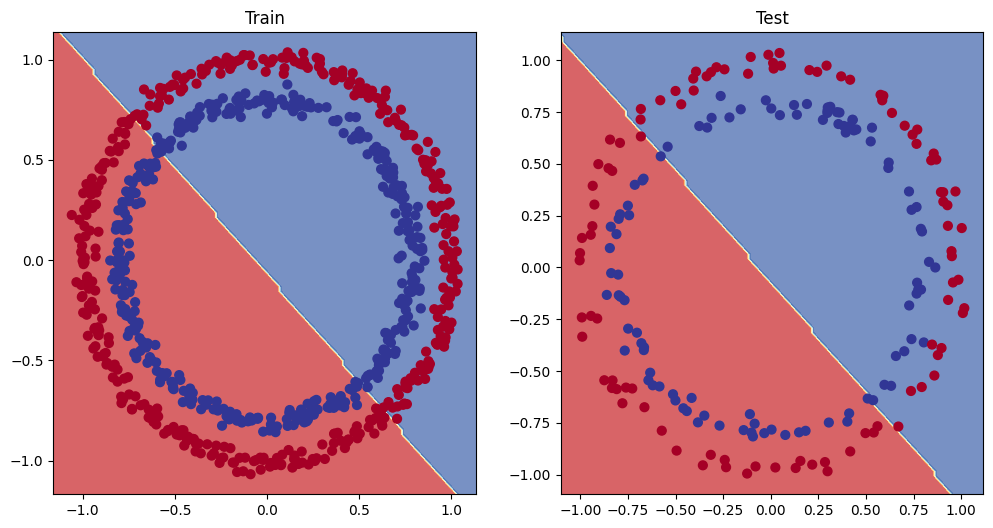

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [ ]:
# 模型效果不好的原因
# 資料分佈是圓形的   但我們的模型試圖使用 linear regression 去分析資料
# 可能需要使用其他分析途徑

# === Improve the model ===
1. Add more layers - 有更多擷取特徵的機會
2. Add more hidden units - 有更多參數可以學習
3. Add more epochs - 延長學習時間
4. Change activation functions
5. Change learning rate
6. Change loss function
  
這邊的改進方法, 專注在模型上  
實際場景 也有可能是訓練資料出問題

In [ ]:
# add layers and hidden units
# 通常在改善模型時 會單個因素 單個因素去調整 才能找到真正出問題的因素

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=8)
        self.layer_2 = nn.Linear(in_features=8, out_features=32)
        self.layer_3 = nn.Linear(in_features=32, out_features=16)
        self.layer_4 = nn.Linear(in_features=16, out_features=1)
    
    def forward(self, x):
        z = self.layer_1(x)
        z = self.layer_2(z)
        z = self.layer_3(z)
        z = self.layer_4(z)
        return z
    
model_2 = CircleModelV1().to(device)
model_2

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_4): Linear(in_features=16, out_features=1, bias=True)
)

In [ ]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create optimizer
optimizer = torch.optim.SGD(params = model_2.parameters(),
                lr = 0.1)

In [ ]:
# training loop
torch.manual_seed(42)

# 指定訓練次數
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# 
for epoch in range(epochs):
    # Training !!!
    model_2.train()

    # 1. Forward pass
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train,
               y_pred = y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Testing !!!
    model_2.eval()
    with torch.no_grad():
        # 1. Forward pass
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate
        test_loss = loss_fn(test_logits,
                    y_test)
        test_acc = accuracy_fn(y_true = y_test,
                     y_pred = test_pred)
        
        # Print out process
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}")
            print(f"Loss: {loss:.4f}, Acc:{acc:.2f}%")
            print(f"Test loss: {test_loss:.4f}, Test acc:{test_acc:.2f}%")
            print("=" * 50)

Epoch: 0
Loss: 0.6942, Acc:50.00%
Test loss: 0.6928, Test acc:50.00%
Epoch: 100
Loss: 0.6931, Acc:51.88%
Test loss: 0.6936, Test acc:47.00%
Epoch: 200
Loss: 0.6930, Acc:51.75%
Test loss: 0.6943, Test acc:45.50%
Epoch: 300
Loss: 0.6930, Acc:51.38%
Test loss: 0.6945, Test acc:45.50%
Epoch: 400
Loss: 0.6930, Acc:51.25%
Test loss: 0.6946, Test acc:46.00%
Epoch: 500
Loss: 0.6930, Acc:51.12%
Test loss: 0.6947, Test acc:46.00%
Epoch: 600
Loss: 0.6930, Acc:51.12%
Test loss: 0.6947, Test acc:46.00%
Epoch: 700
Loss: 0.6930, Acc:51.00%
Test loss: 0.6947, Test acc:46.00%
Epoch: 800
Loss: 0.6930, Acc:51.00%
Test loss: 0.6947, Test acc:46.00%
Epoch: 900
Loss: 0.6930, Acc:51.00%
Test loss: 0.6947, Test acc:46.00%


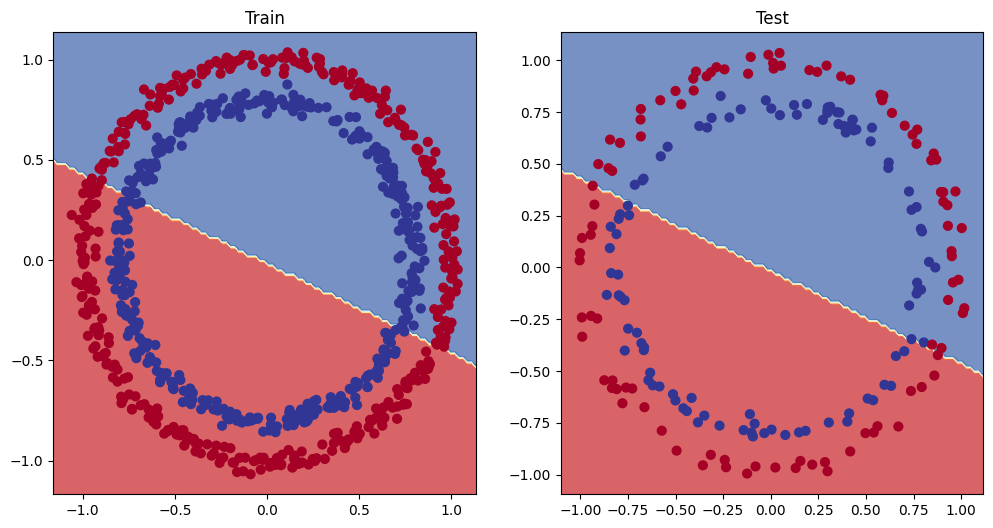

In [ ]:
# 畫圖檢視 again
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

# === Non-linearity ===

# 4.1 Build the model by using non-linearity

In [ ]:
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x
    
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# Set loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.SGD(model_3.parameters(),
                lr = 0.1)

# 4.2 Train model with non-linear

In [ ]:
# Random seeds
torch.manual_seed(42)

# 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# 
epochs = 2000

# 
for epoch in range(epochs):
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train,
               y_pred = y_pred)

    # 3. Optimizer
    optimizer.zero_grad()

    # 4. Loass backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    # Train !!!
    with torch.no_grad():
        # 1. Forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test,
                     y_pred = test_pred)
    
        # Print out process
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}")
            print(f"Loss: {loss:.4f}, Acc:{acc:.2f}%")
            print(f"Test loss: {test_loss:.4f}, Test acc:{test_acc:.2f}%")
            print("=" * 50)

Epoch: 0
Loss: 0.6929, Acc:50.00%
Test loss: 0.6932, Test acc:50.00%
Epoch: 100
Loss: 0.6912, Acc:52.88%
Test loss: 0.6910, Test acc:52.50%
Epoch: 200
Loss: 0.6898, Acc:53.37%
Test loss: 0.6894, Test acc:55.00%
Epoch: 300
Loss: 0.6879, Acc:53.00%
Test loss: 0.6872, Test acc:56.00%
Epoch: 400
Loss: 0.6852, Acc:52.75%
Test loss: 0.6841, Test acc:56.50%
Epoch: 500
Loss: 0.6810, Acc:52.75%
Test loss: 0.6794, Test acc:56.50%
Epoch: 600
Loss: 0.6751, Acc:54.50%
Test loss: 0.6729, Test acc:56.00%
Epoch: 700
Loss: 0.6666, Acc:58.38%
Test loss: 0.6632, Test acc:59.00%
Epoch: 800
Loss: 0.6516, Acc:64.00%
Test loss: 0.6476, Test acc:67.50%
Epoch: 900
Loss: 0.6236, Acc:74.00%
Test loss: 0.6215, Test acc:79.00%
Epoch: 1000
Loss: 0.5682, Acc:87.75%
Test loss: 0.5738, Test acc:86.50%
Epoch: 1100
Loss: 0.4815, Acc:93.50%
Test loss: 0.4993, Test acc:90.50%
Epoch: 1200
Loss: 0.3706, Acc:97.75%
Test loss: 0.4059, Test acc:92.00%
Epoch: 1300
Loss: 0.2546, Acc:99.00%
Test loss: 0.3033, Test acc:96.50%
Epoc

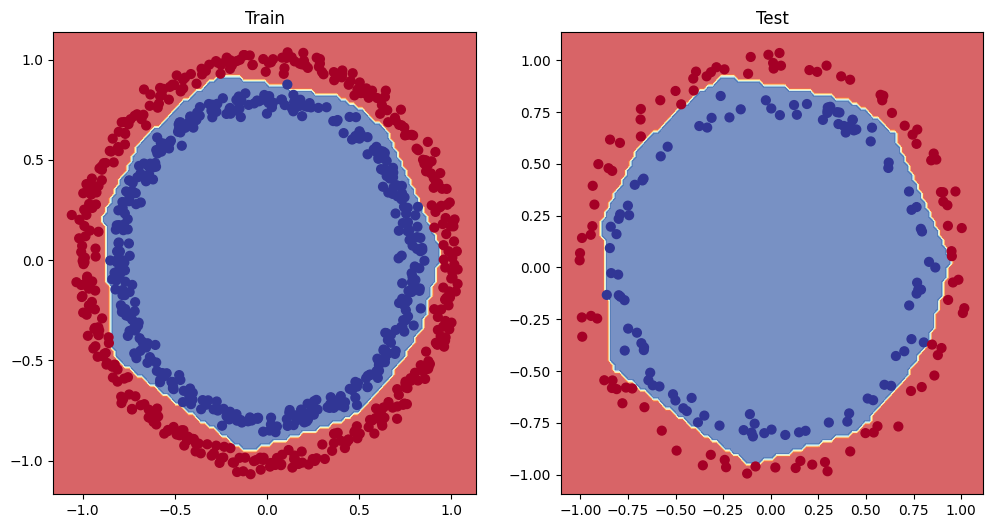

In [ ]:
# 畫圖檢視 again
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

# === Multi-class classification ===

# 5.1 Creating dataset

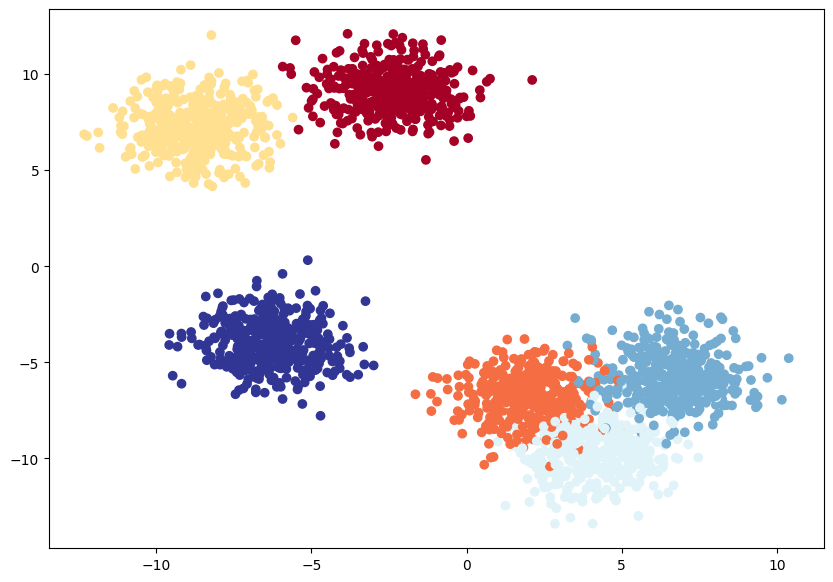

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# 超參數
num_classes = 6
num_features = 3
random_seed = 42

# 1. Creat datasets
X_blob, y_blob = make_blobs(n_samples = 2400,
                 n_features = num_features,
                 centers = num_classes,
                 cluster_std = 1.2, # 賦予資料隨機性
                 random_state = random_seed)

# 2. Trun data into tensor
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
# Pytorch 在target 這邊使用的資料型態 是 LongTensor
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

# 3. Split
X_train, X_test, y_train, y_test = train_test_split(X_blob,
                              y_blob,
                              test_size = 0.2,
                              random_state = random_seed)

# 4. Plot the data (Visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

# 5.2 Build multi-class classification model

In [ ]:
# Device 判斷
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Build
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    
# model and set to device
model_4 = BlobModel(input_features=3,
            output_features=6,
            hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=6, bias=True)
  )
)

# 5.3 Create loss function and optimizer

In [ ]:
# Create loss function 
loss_fn = nn.CrossEntropyLoss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(),
                lr=0.1)

In [ ]:
# Set accuracy_fn
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

# 5.4 Getting prediction (check model)

In order to evaluate & train & test our model  
We need to convert model's output to prediction probability and then cpnvert to label


In [ ]:
model_4.eval()

with torch.no_grad():
    y_logits = model_4(X_test.to(device))

y_logits[:2]   # [-0.1535, -0.4210,  0.2340, -0.2328, -0.0810,  0.1347] 與答案的資料型態不一樣

tensor([[-0.1461, -0.4177,  0.2292, -0.2299, -0.0854,  0.1278],
        [-0.0320, -0.1760,  0.3228, -0.0183, -0.0499,  0.0746]])

In [ ]:
y_test[:2]

tensor([3, 4])

In [ ]:
# convert model's output to prediction probability
y_pred_probs = torch.softmax(y_logits, dim=1)

print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.1461, -0.4177,  0.2292, -0.2299, -0.0854,  0.1278],
        [-0.0320, -0.1760,  0.3228, -0.0183, -0.0499,  0.0746],
        [-0.2256, -0.5198,  0.2202, -0.3138, -0.0830,  0.1814],
        [-0.0268, -0.2013,  0.2987, -0.0492, -0.0532,  0.0654],
        [-0.3217, -0.5093,  0.0467, -0.1800, -0.0207,  0.1859]])
tensor([[0.1535, 0.1170, 0.2234, 0.1412, 0.1631, 0.2019],
        [0.1562, 0.1353, 0.2228, 0.1584, 0.1535, 0.1738],
        [0.1454, 0.1083, 0.2271, 0.1331, 0.1677, 0.2184],
        [0.1594, 0.1339, 0.2207, 0.1559, 0.1553, 0.1748],
        [0.1344, 0.1114, 0.1943, 0.1549, 0.1816, 0.2233]])


In [ ]:
# convert prediction probability to label

y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([2, 2, 2, 2, 5, 3, 2, 2, 5, 3])

In [ ]:
y_test[:10]   # 格式 一樣了

tensor([3, 4, 3, 4, 5, 0, 4, 4, 1, 0])

# 5.5 Create training loop and testing loop

In [ ]:
y_logits

tensor([[-0.1461, -0.4177,  0.2292, -0.2299, -0.0854,  0.1278],
        [-0.0320, -0.1760,  0.3228, -0.0183, -0.0499,  0.0746],
        [-0.2256, -0.5198,  0.2202, -0.3138, -0.0830,  0.1814],
        ...,
        [-0.0143, -0.2224,  0.2513, -0.0318, -0.1375,  0.0312],
        [-0.0309, -0.1692,  0.3209,  0.0033, -0.0741,  0.0688],
        [-0.0123, -0.2688,  0.2325, -0.1287, -0.0676,  0.0392]])

In [ ]:
# Fit the model to the data
torch.manual_seed(42)

# Set number of epochs
epochs = 500

# Put data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
for epoch in range(epochs):
    # Training !!!
    model_4.train()

    y_logits = model_4(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train,
               y_pred = y_pred)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # Testing !!!
    model_4.eval()
    with torch.no_grad():
        test_logits = model_4(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test,
                      y_pred = test_preds)

    # print process
    if epoch % 50 == 0:
        print("Epoch: ", epoch)
        print(f"Train loss: {loss:.2f} | Train acc: {acc:.2f}%")
        print(f"Test loss: {test_loss:.2f} | Test acc: {test_acc:.2f}%")
        print("=" * 50)

Epoch:  0
Train loss: 1.87 | Train acc: 14.32%
Test loss: 1.77 | Test acc: 16.46%
Epoch:  50
Train loss: 0.43 | Train acc: 95.68%
Test loss: 0.40 | Test acc: 96.04%
Epoch:  100
Train loss: 0.20 | Train acc: 98.18%
Test loss: 0.19 | Test acc: 97.29%
Epoch:  150
Train loss: 0.14 | Train acc: 98.85%
Test loss: 0.13 | Test acc: 98.54%
Epoch:  200
Train loss: 0.10 | Train acc: 99.22%
Test loss: 0.10 | Test acc: 98.75%
Epoch:  250
Train loss: 0.08 | Train acc: 99.22%
Test loss: 0.09 | Test acc: 98.96%
Epoch:  300
Train loss: 0.07 | Train acc: 99.17%
Test loss: 0.07 | Test acc: 98.96%
Epoch:  350
Train loss: 0.06 | Train acc: 99.22%
Test loss: 0.07 | Test acc: 98.96%
Epoch:  400
Train loss: 0.05 | Train acc: 99.22%
Test loss: 0.06 | Test acc: 98.96%
Epoch:  450
Train loss: 0.05 | Train acc: 99.22%
Test loss: 0.06 | Test acc: 98.75%


# 5.6 Make prediction 

In [ ]:
model_4.eval()
with torch.no_grad():
    y_logits = model_4(X_test)

y_logits[:10]

tensor([[  1.3383,  -1.1660,  -4.0328,   9.5063,   1.4822,  -6.3484],
        [ -0.6791,  -0.2635,  -0.4956,  -0.6522,   2.8831,  -0.7203],
        [  1.3733,  -3.8097,  -3.4271,   9.7273,  -0.0946,  -5.7858],
        [ -0.6791,  -0.2635,  -0.4956,  -0.6522,   2.8831,  -0.7203],
        [-11.8949,   3.7071,  -1.8227, -14.2567,  -6.8237,  11.1880],
        [  9.2352, -14.5269,  -1.5756,  -1.7132,  -7.8152,  -6.3700],
        [ -0.6791,  -0.2635,  -0.4956,  -0.6522,   2.8831,  -0.7203],
        [ -1.0717,   0.5871,  -0.8411,  -1.0204,   2.7487,  -0.5723],
        [ -6.3566,   9.3527,  -4.2112,  -6.3181,   0.1787,   2.2960],
        [  8.3450, -14.7084,  -0.3029,  -2.7308,  -7.7213,  -5.4640]])

In [ ]:
y_preds_probs = torch.softmax(y_logits, dim=1)
y_preds_probs[:10]

tensor([[2.8340e-04, 2.3163e-05, 1.3175e-06, 9.9936e-01, 3.2724e-04, 1.3005e-07],
        [2.4423e-02, 3.7009e-02, 2.9344e-02, 2.5090e-02, 8.6070e-01, 2.3439e-02],
        [2.3540e-04, 1.3207e-06, 1.9364e-06, 9.9971e-01, 5.4235e-05, 1.8308e-07],
        [2.4423e-02, 3.7009e-02, 2.9344e-02, 2.5090e-02, 8.6070e-01, 2.3439e-02],
        [9.4408e-11, 5.6346e-04, 2.2350e-06, 8.8976e-12, 1.5044e-08, 9.9943e-01],
        [9.9996e-01, 4.7889e-11, 2.0181e-05, 1.7585e-05, 3.9363e-08, 1.6702e-07],
        [2.4423e-02, 3.7009e-02, 2.9344e-02, 2.5090e-02, 8.6070e-01, 2.3439e-02],
        [1.7909e-02, 9.4082e-02, 2.2556e-02, 1.8853e-02, 8.1709e-01, 2.9510e-02],
        [1.5035e-07, 9.9903e-01, 1.2849e-06, 1.5626e-07, 1.0360e-04, 8.6080e-04],
        [9.9981e-01, 9.7267e-11, 1.7547e-04, 1.5480e-05, 1.0530e-07, 1.0064e-06]])

In [ ]:
y_preds = torch.argmax(y_preds_probs, dim=1)

In [ ]:
y_test

print( len(y_preds == y_test) / len(y_preds) )
# 準確率 100%
# 教程僅使用兩種特徵 我們設定三維   所以沒有辦法畫圖

1.0


# 額外補充 (Other way to evaluate model)
1. 目前僅使用 Accuracy
2. Precision
3. Recall
4. F1-score
5. Confusion matrix
6. Classification report

In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=num_classes).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_test)

tensor(0.9875)